# Acquiring and exploring our own EEG data using a Bitbrain 16-channel headset

**Authors**:

 - Javi Rameerez javi@rameerez.com | [@rameerez [tw]](http://twitter.com/rameerez)

---


_This code is Open Source, released under a GPL License._

We will be using a 16-ch, wet [Bitbrain](https://bitbrain.com) EEG headset like this one:

<img src="assets/bitbrain-eeg-headset.jpg" alt="Bitbrain's EEG headset" style="width: 1024px;"/>


## Electrode placement

<img src="assets/eeg-10-20-location.png" alt="International EEG 10-20 system" style="width: 300px;"/>

**TODO**: this explanation is incomplete! Detail the location of each electrode and correspondance with channels

Basically, we've used 8 electrodes in C1 through C4 and FC1 through FC4, the next 4 in the frontal cortex and the next 4 in TODO.

Reference is Cz and ground is A1.

## Methodology

### Sampling methodology & EEG data structure

Our headset makes about 256 measurements per second and per channel (we need to actually verify this with the manufacturer).

The stored EEG dataset looks like this:

| timestamp   | sequence | battery | flags | EEG-ch1         | EEG-ch2 | ... | EEG-ch16         |
|-------------|----------|---------|-------|-----------------|---------|-----|------------------|
| 11333317601 | 24377    | -2      | 0     | 14440.732098739 | ...     | ... | -1316.9463302375 |
| ...         | ...      | ...     | ...   | ...             | ...     | ... | ...              |
| 11333350144 | 24378    | -2      | 0     | ...             | ...     | ... | ...              |


The EEG data contains rows, each row corresponds to one measurement and is identified with a `timestamp`. The first 8 measurements share the same `timestamp`, the next 8 measurements share another (non consecutive) timestamp, and so on.

What a `timestamp` is remains unknown for the moment (it is not milliseconds nor seconds since Jan 1, 1970 -- it's not a UNIX timestamp as far as we know). But we know that approximately every second, the system stores 256 measurements (belonging to 32 different timestamps).

### Labelling tasks

We asked the subject to sit down and remain calm. Then, the labelling task starts. For 10 seconds, the subject needs to think about moving the left hand. Then, for another 10 seconds, the subject needs to thing about moving the right hand. Finally, for 10 seconds, the subject rests.

## Data exploration

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import pandas as pd
%matplotlib inline

In [0]:
cd /content/drive/My\ Drive/brain-computer-interfacing


/content/drive/My Drive/brain-computer-interfacing


In [0]:
df = pd.read_csv("data/3-thinking-about-moving-hands-2-BBT-E16-AAA005-2019-11-08_18-45-48/EEG.csv")

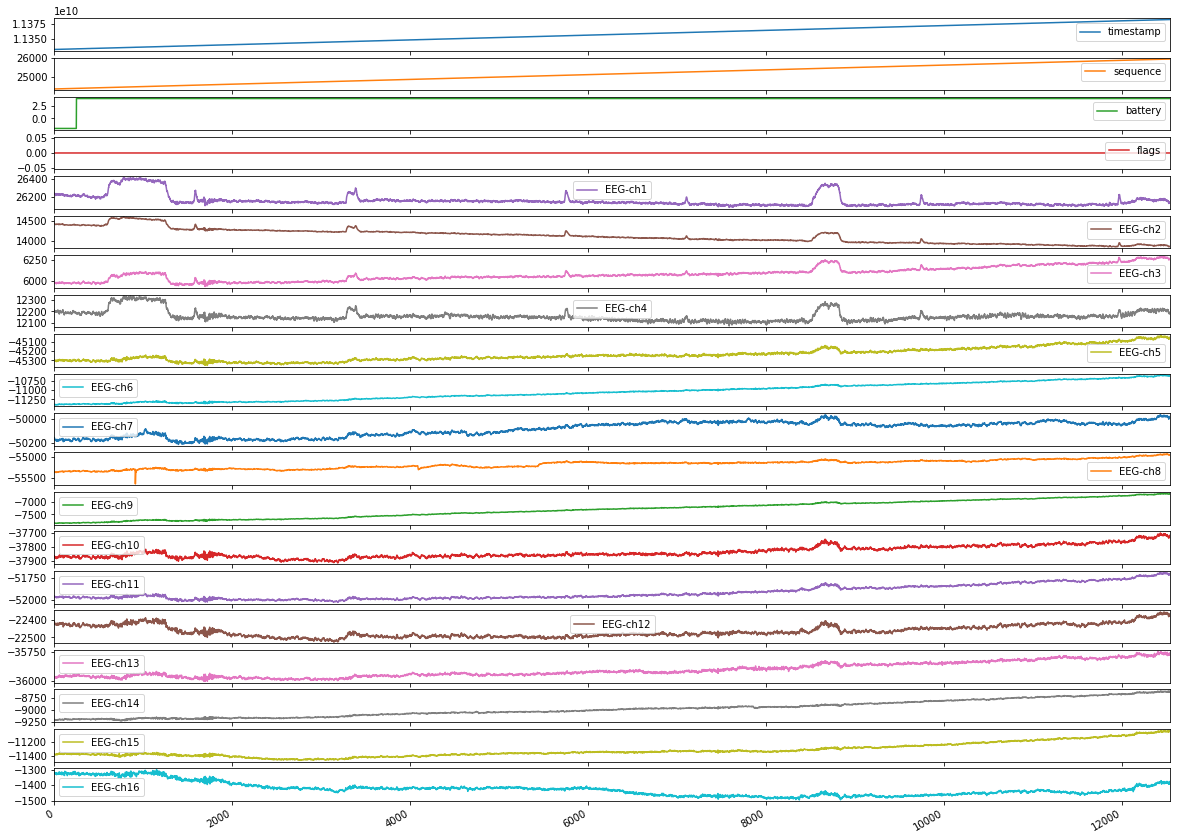

In [0]:
df.plot(subplots=True, figsize=(20, 16));

## Data labelling

For dataset #3, we know that we started the labelling task at `starting_seconds`.

Each second contains many `samples_per_second`.

The first measurement of the labelling task is then `starting_sample`.

Each labelling task lasts for `seconds_per_training_label`.

This way we can know the measurement corresponding to the start and end of every labelling task.

In [0]:
starting_seconds = 12.52
samples_per_second = 256

starting_sample = int(starting_seconds * samples_per_second)

seconds_per_training_label = 10
samples_per_training_label = seconds_per_training_label * samples_per_second

first_label_start = starting_sample
second_label_start = starting_sample + samples_per_training_label
third_label_start = second_label_start + samples_per_training_label
third_label_end = third_label_start + samples_per_training_label

In [0]:
for i, row in df.iterrows():
    if first_label_start <= i <= second_label_start:
        df.at[i, 'label'] = "left"
        df.at[i, 'label_code'] = 1
    elif second_label_start <= i <= third_label_start:
        df.at[i, 'label'] = "right"
        df.at[i, 'label_code'] = 2
    elif third_label_start <= i <= third_label_end:
        df.at[i, 'label'] = "rest"
        df.at[i, 'label_code'] = 0
    else:
        df.at[i, 'label'] = "none"
        df.at[i, 'label_code'] = -1

In [0]:
df["label_code"] = df["label_code"].astype(int)

In [0]:
df.to_pickle("data/3-thinking-about-moving-hands-2-BBT-E16-AAA005-2019-11-08_18-45-48/labelled-eeg.pkl")

## Exploring the EEG by label

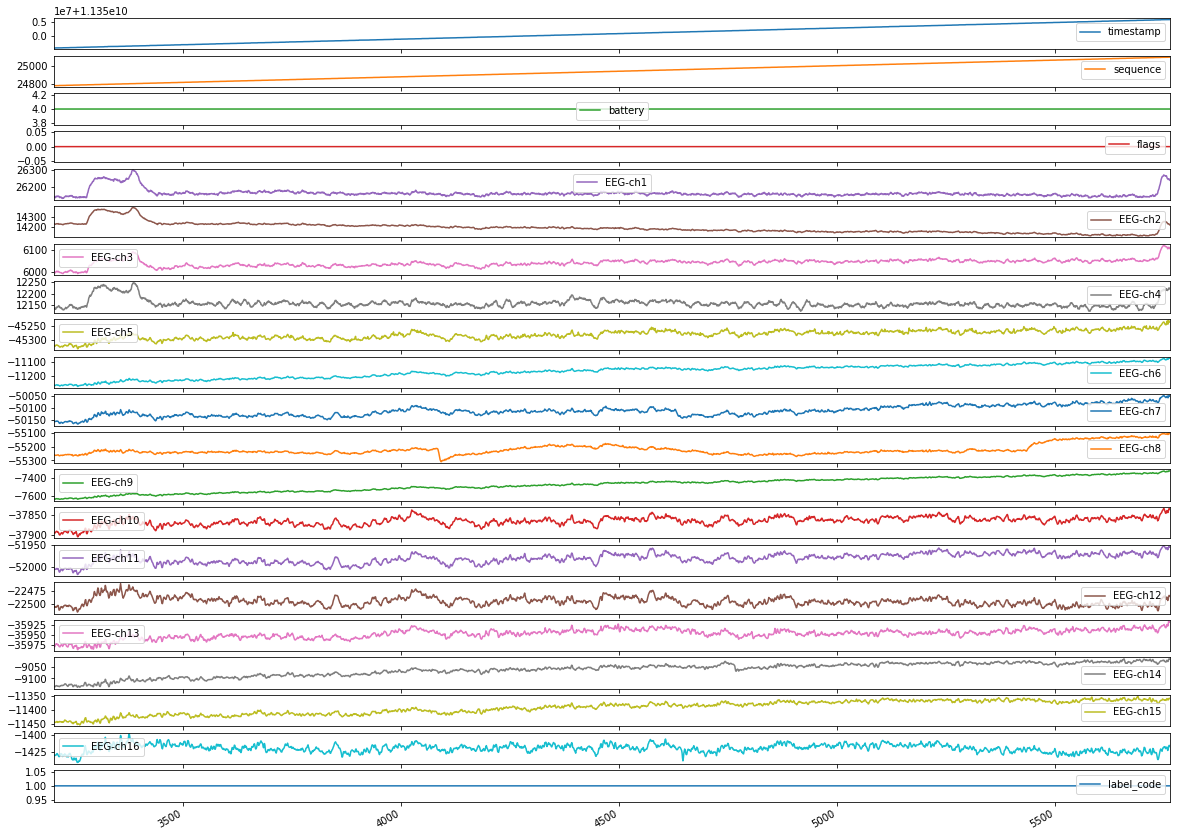

In [0]:
df.loc[df['label'] == "left"].plot(subplots=True, figsize=(20, 16));

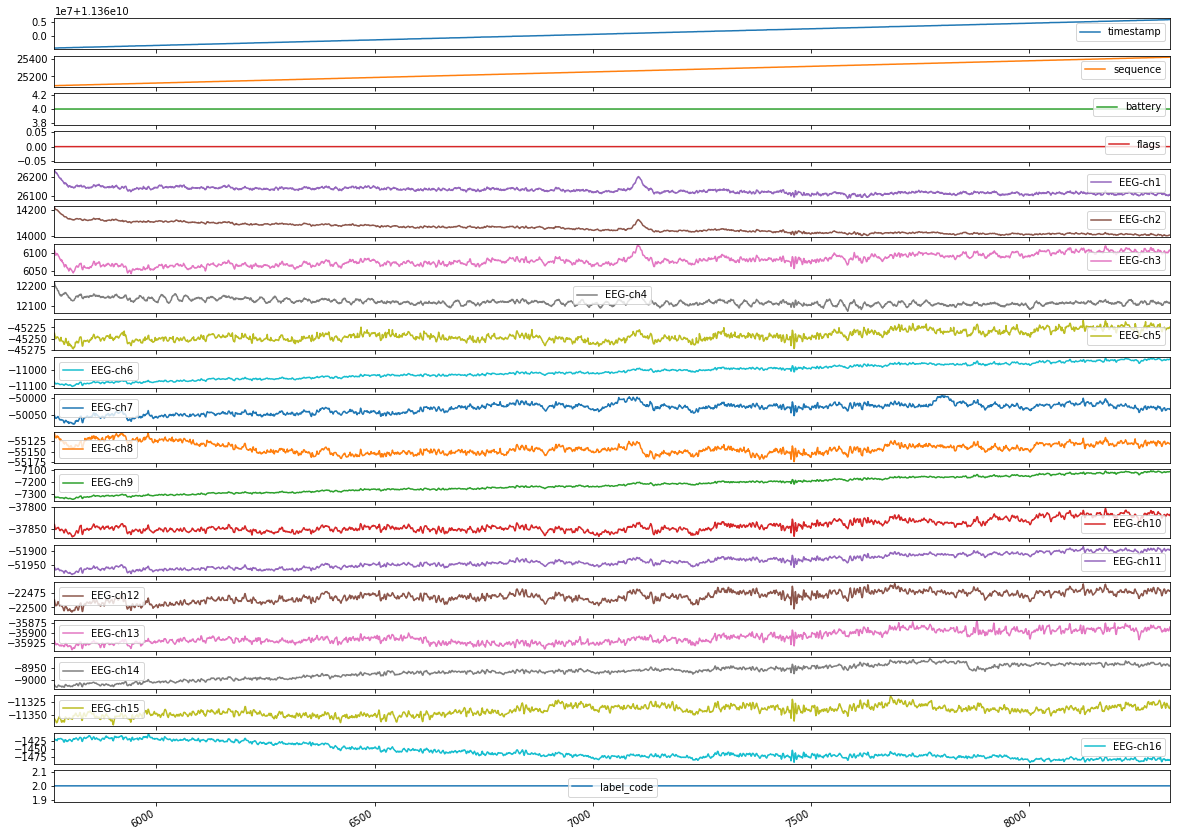

In [0]:
df.loc[df['label'] == "right"].plot(subplots=True, figsize=(20, 16));

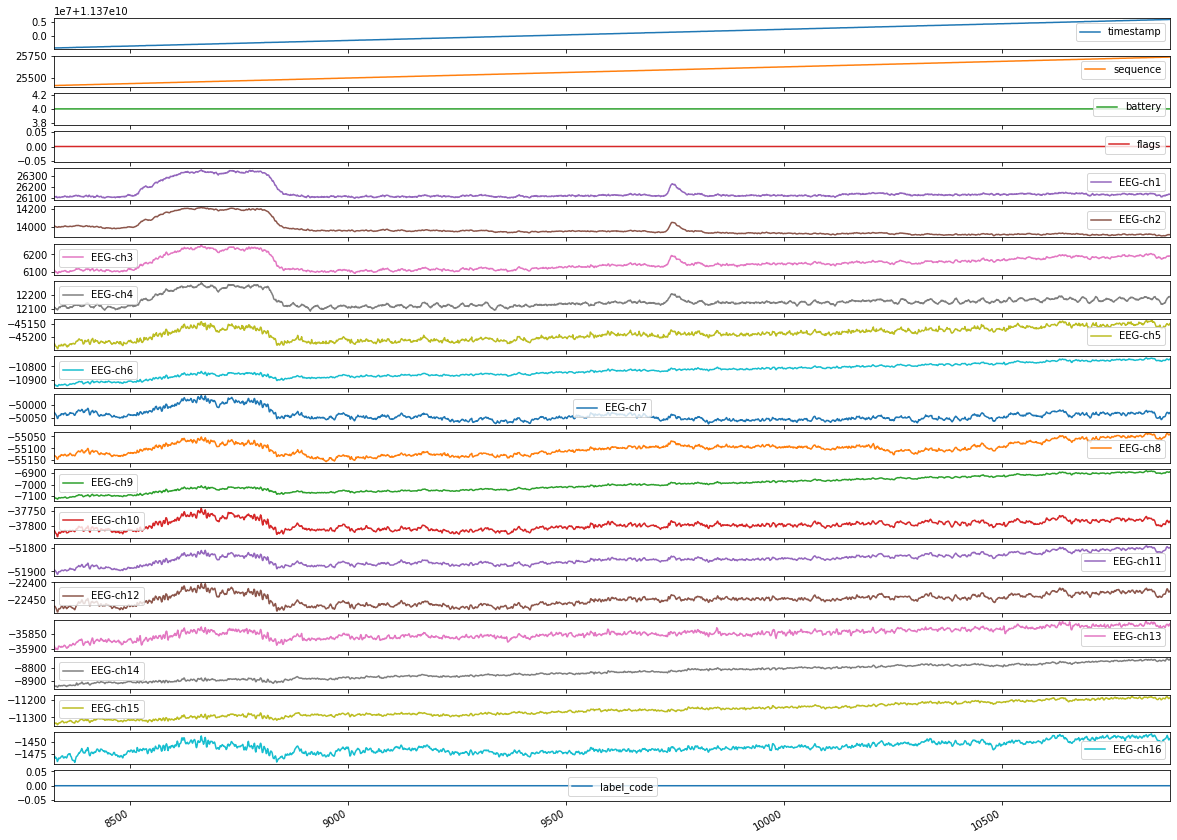

In [0]:
df.loc[df['label'] == "rest"].plot(subplots=True, figsize=(20, 16));

In [0]:
df = df.loc[df['label'] != 'none'] # Eliminamos las lecturas que no pertenecen a ninguna clase

In [0]:
df = df.drop([3205]) # Quitamos el primer registro para que cada clase todos tenga 2560 lecturas
df.reset_index(inplace = True)

In [0]:
df = df.drop(columns=(['timestamp', 'sequence', 'battery', 'flags', 'index']), axis=1)

In [0]:
df_nolabels = df.drop(columns=(['label', 'label_code']), axis=1)

In [0]:
df.head()

,EEG-ch1,EEG-ch2,EEG-ch3,EEG-ch4,EEG-ch5,EEG-ch6,EEG-ch7,EEG-ch8,EEG-ch9,EEG-ch10,EEG-ch11,EEG-ch12,EEG-ch13,EEG-ch14,EEG-ch15,EEG-ch16,label,label_code
0,26138.987011,14228.417957,5994.951218,12136.365004,-45320.959518,-11269.891145,-50157.911030,-55260.811891,-7639.999494,-37894.393594,-52005.940823,-22505.810081,-35979.271121,-9135.810967,-11444.156899,-1431.018488,left,1
1,26134.971671,14226.580635,5994.002138,12133.396086,-45320.144282,-11269.440940,-50158.701930,-55261.846145,-7640.109003,-37893.748706,-52006.123339,-22505.201696,-35975.426128,-9134.387347,-11444.193402,-1430.641289,left,1
2,26136.735987,14228.624808,5995.340585,12131.838620,-45317.175364,-11266.897892,-50157.996204,-55263.196760,-7636.945402,-37892.239912,-52006.257183,-22504.654150,-35974.002508,-9132.184993,-11444.448924,-1430.994153,left,1
3,26143.768915,14230.291782,5999.453266,12140.331673,-45316.980681,-11265.547277,-50156.937614,-55262.381524,-7633.939981,-37890.767621,-52005.186426,-22505.566727,-35972.031341,-9130.591025,-11443.073974,-1430.373600,left,1
4,26142.771164,14231.228695,6000.755210,12140.842716,-45315.982930,-11264.622532,-50157.436490,-55262.004325,-7634.292844,-37890.049727,-52004.857898,-22505.177361,-35973.211608,-9130.518019,-11442.441254,-1429.083824,left,1


In [0]:
len(df.loc[df['label'] == "left"])

2560

In [0]:
len(df.loc[df['label'] == "right"])

2560

In [0]:
len(df.loc[df['label'] == "rest"])

2560

In [0]:
epochs = epoch(df_nolabels.to_numpy(),2560)
epochs.shape

(2560, 16, 3)

In [0]:
fs = 256
feature_matrix = compute_feature_matrix(epochs, fs)
feature_matrix.shape

(3, 64)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f7757d64e48>,
      dtype=object)

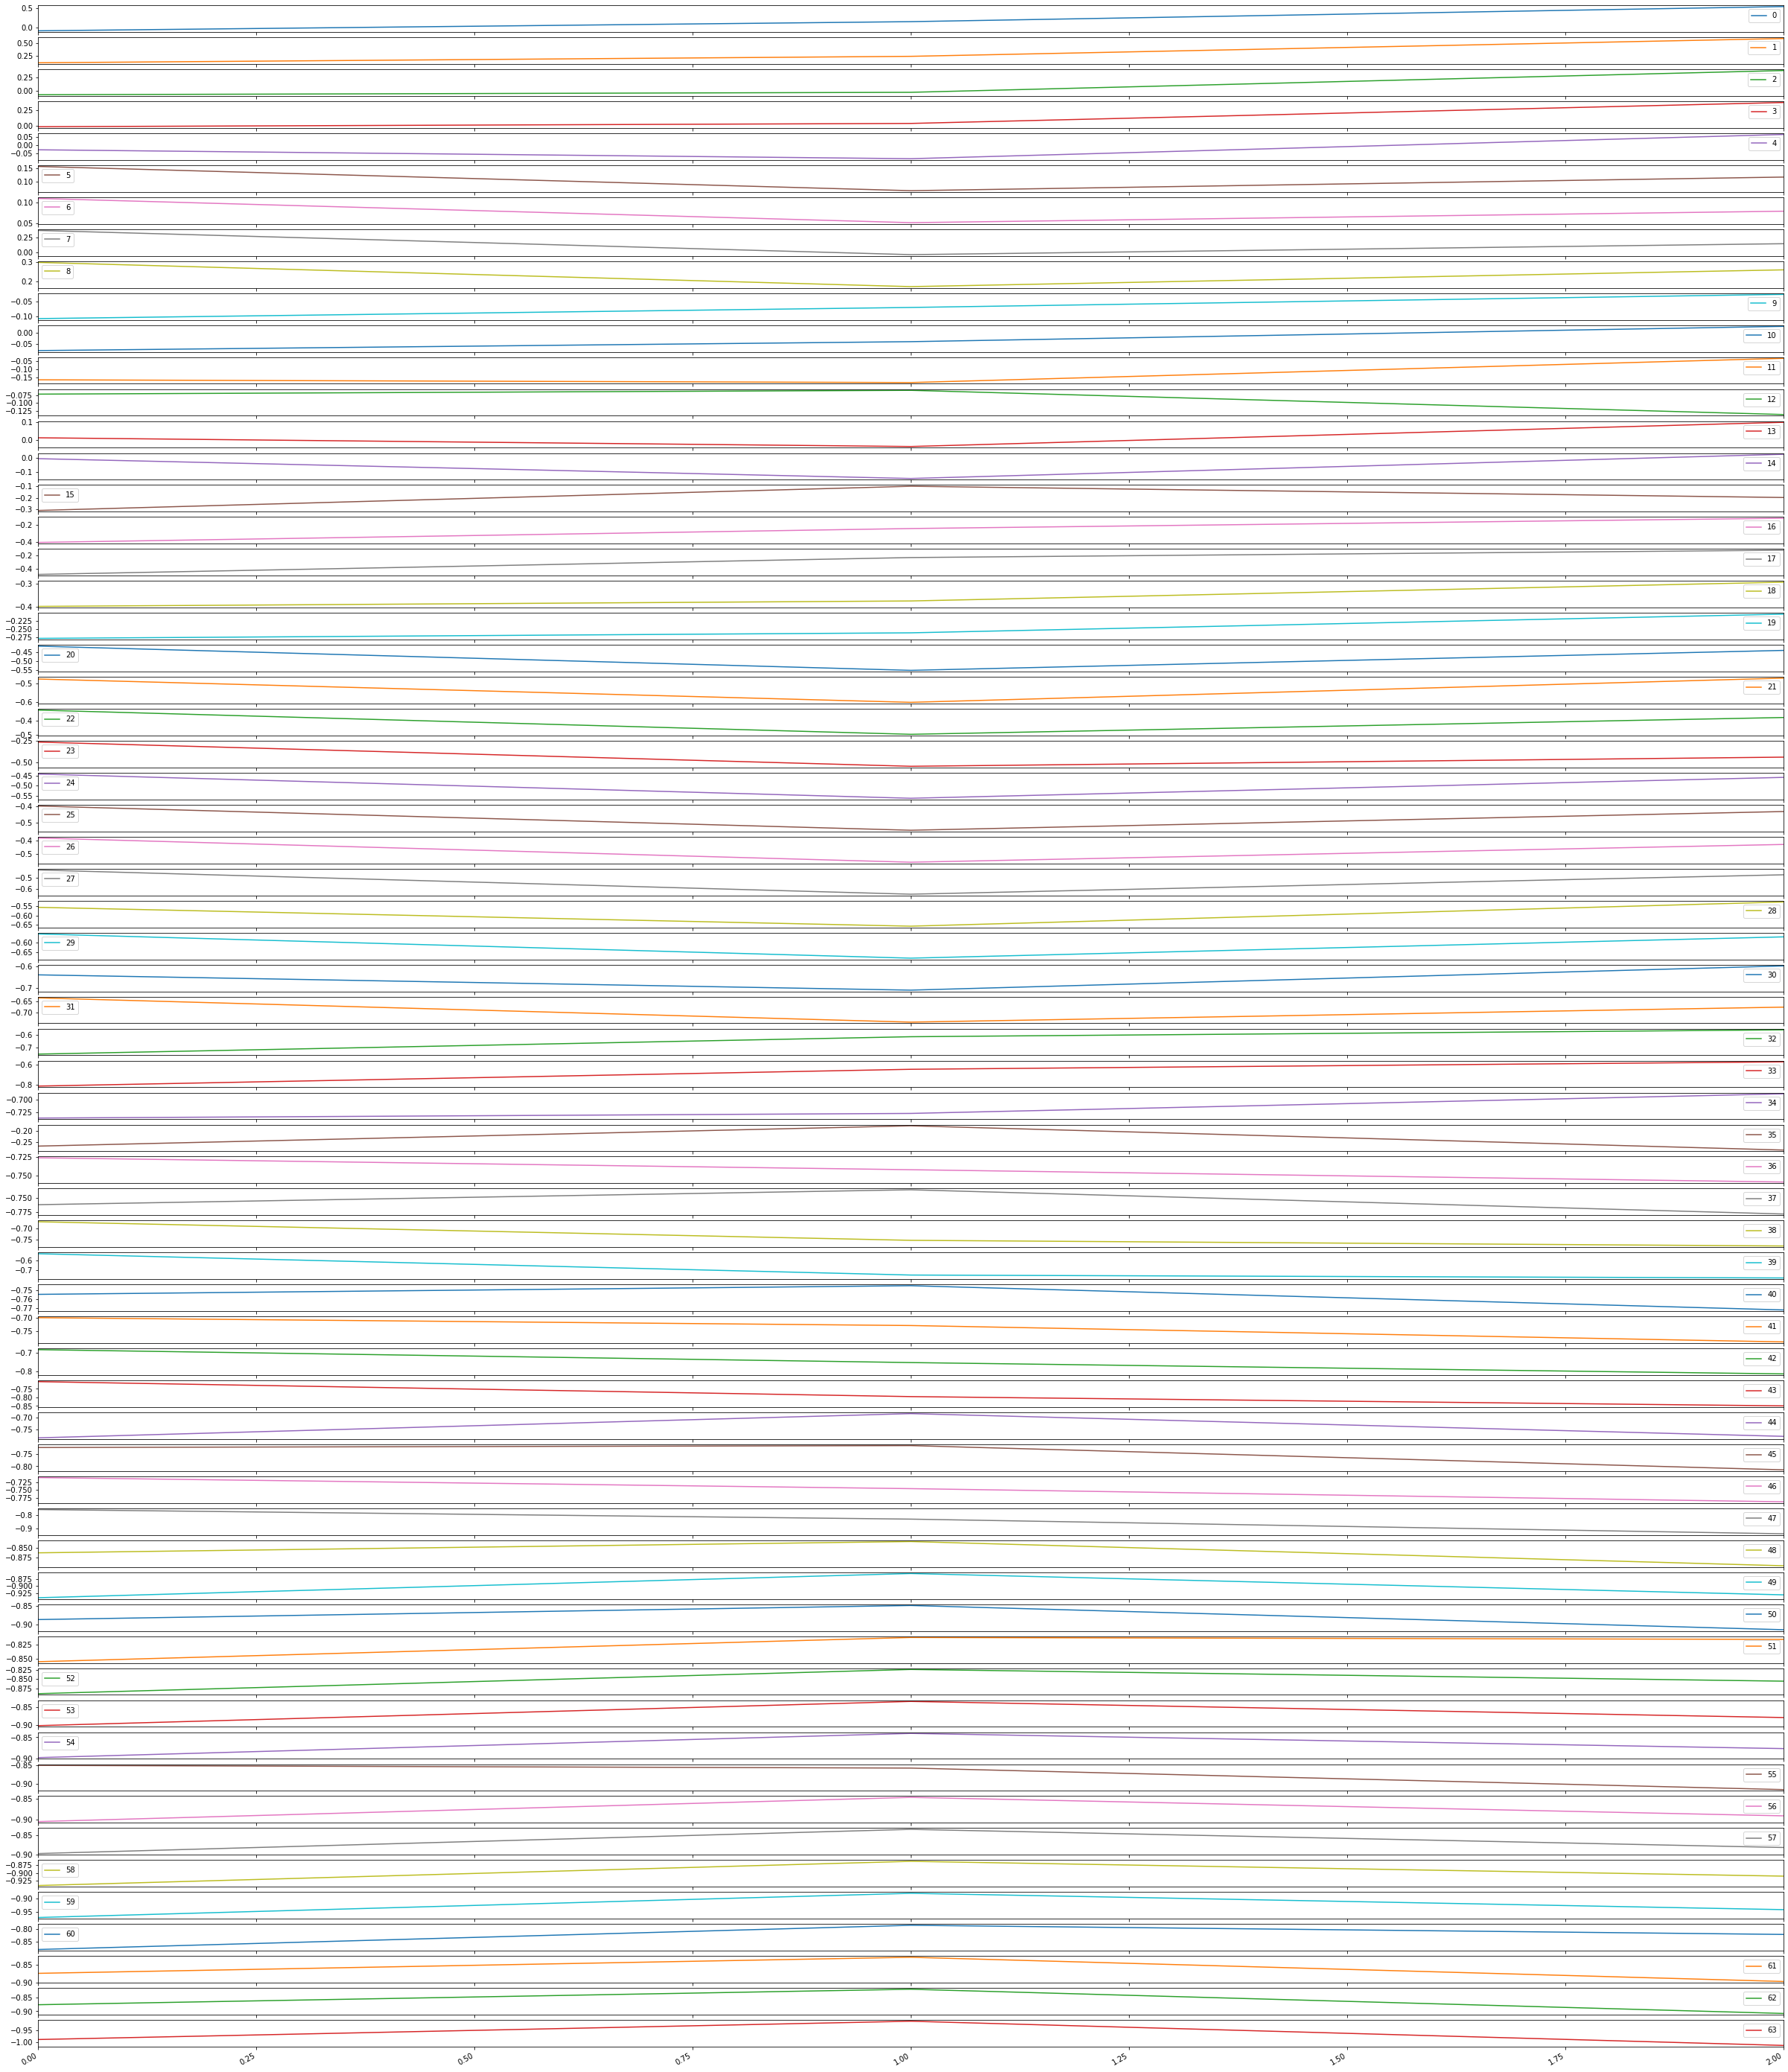

In [0]:
df_ft = pd.DataFrame(feature_matrix)
df_ft.plot(subplots=True, figsize=(42,56))

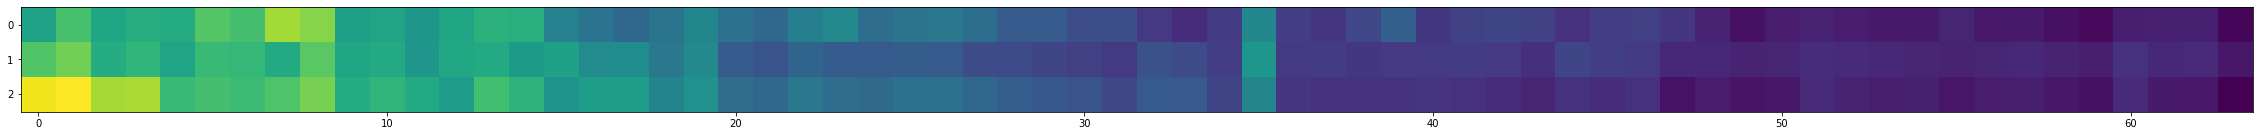

In [0]:
plt.figure(figsize=(40, 16))
plt.imshow(df_ft.values)

In [0]:
# -*- coding: utf-8 -*-
"""
BCI Workshop Auxiliary Tools
Created on Fri May 08 15:34:59 2015
@author: Cassani
"""

import os
import sys
from tempfile import gettempdir
from subprocess import call

import matplotlib.pyplot as plt
import numpy as np
from sklearn import svm
from scipy.signal import butter, lfilter, lfilter_zi
%matplotlib inline

NOTCH_B, NOTCH_A = butter(4, np.array([55, 65])/(256/2), btype='bandstop')


def plot_multichannel(data, params=None):
    """Create a plot to present multichannel data.
    Args:
        data (numpy.ndarray):  Multichannel Data [n_samples, n_channels]
        params (dict): information about the data acquisition device
    TODO Receive labels as arguments
    """
    fig, ax = plt.subplots()

    n_samples = data.shape[0]
    n_channels = data.shape[1]

    if params is not None:
        fs = params['sampling frequency']
        names = params['names of channels']
    else:
        #fs = 1
        fs = 256
        names = [''] * n_channels

    time_vec = np.arange(n_samples) / float(fs)

    data = np.fliplr(data)
    offset = 0
    for i_channel in range(n_channels):
        data_ac = data[:, i_channel] - np.mean(data[:, i_channel])
        offset = offset + 2 * np.max(np.abs(data_ac))
        ax.plot(time_vec, data_ac + offset, label=names[i_channel])

    ax.set_xlabel('Time [s]')
    ax.set_ylabel('Amplitude')
    plt.legend()
    plt.draw()


def epoch(data, samples_epoch, samples_overlap=0):
    """Extract epochs from a time series.
    Given a 2D array of the shape [n_samples, n_channels]
    Creates a 3D array of the shape [wlength_samples, n_channels, n_epochs]
    Args:
        data (numpy.ndarray or list of lists): data [n_samples, n_channels]
        samples_epoch (int): window length in samples
        samples_overlap (int): Overlap between windows in samples
    Returns:
        (numpy.ndarray): epoched data of shape
    """

    if isinstance(data, list):
        data = np.array(data)

    n_samples, n_channels = data.shape

    samples_shift = samples_epoch - samples_overlap

    n_epochs =  int(np.floor((n_samples - samples_epoch) / float(samples_shift)) + 1)

    # Markers indicate where the epoch starts, and the epoch contains samples_epoch rows
    markers = np.asarray(range(0, n_epochs + 1)) * samples_shift
    markers = markers.astype(int)

    # Divide data in epochs
    epochs = np.zeros((samples_epoch, n_channels, n_epochs))

    for i in range(0, n_epochs):
        epochs[:, :, i] = data[markers[i]:markers[i] + samples_epoch, :]

    return epochs


def compute_feature_vector(eegdata, fs):
    """Extract the features from the EEG.
    Args:
        eegdata (numpy.ndarray): array of dimension [number of samples,
                number of channels]
        fs (float): sampling frequency of eegdata
    Returns:
        (numpy.ndarray): feature matrix of shape [number of feature points,
            number of different features]
    """
    # 1. Compute the PSD
    winSampleLength, nbCh = eegdata.shape

    # Apply Hamming window
    w = np.hamming(winSampleLength)
    dataWinCentered = eegdata - np.mean(eegdata, axis=0)  # Remove offset
    dataWinCenteredHam = (dataWinCentered.T*w).T

    NFFT = nextpow2(winSampleLength)
    Y = np.fft.fft(dataWinCenteredHam, n=NFFT, axis=0)/winSampleLength
    PSD = 2*np.abs(Y[0:int(NFFT/2), :])
    f = fs/2*np.linspace(0, 1, int(NFFT/2))

    # SPECTRAL FEATURES
    # Average of band powers
    # Delta <4
    ind_delta, = np.where(f < 4)
    meanDelta = np.mean(PSD[ind_delta, :], axis=0)
    # Theta 4-8
    ind_theta, = np.where((f >= 4) & (f <= 8))
    meanTheta = np.mean(PSD[ind_theta, :], axis=0)
    # Alpha 8-12
    ind_alpha, = np.where((f >= 8) & (f <= 12))
    meanAlpha = np.mean(PSD[ind_alpha, :], axis=0)
    # Beta 12-30
    ind_beta, = np.where((f >= 12) & (f < 30))
    meanBeta = np.mean(PSD[ind_beta, :], axis=0)

    feature_vector = np.concatenate((meanDelta, meanTheta, meanAlpha,
                                     meanBeta), axis=0)

    feature_vector = np.log10(feature_vector)

    return feature_vector


def nextpow2(i):
    """
    Find the next power of 2 for number i
    """
    n = 1
    while n < i:
        n *= 2
    return n


def compute_feature_matrix(epochs, fs):
    """
    Call compute_feature_vector for each EEG epoch
    """
    n_epochs = epochs.shape[2]

    for i_epoch in range(n_epochs):
        if i_epoch == 0:
            feat = compute_feature_vector(epochs[:, :, i_epoch], fs).T
            feature_matrix = np.zeros((n_epochs, feat.shape[0])) # Initialize feature_matrix

        feature_matrix[i_epoch, :] = compute_feature_vector(
                epochs[:, :, i_epoch], fs).T

    return feature_matrix


def train_classifier(feature_matrix_0, feature_matrix_1, algorithm='SVM'):
    """Train a binary classifier.
    Train a binary classifier. First perform Z-score normalization, then
    fit
    Args:
        feature_matrix_0 (numpy.ndarray): array of shape (n_samples,
            n_features) with examples for Class 0
        feature_matrix_0 (numpy.ndarray): array of shape (n_samples,
            n_features) with examples for Class 1
        alg (str): Type of classifer to use. Currently only SVM is
            supported.
    Returns:
        (sklearn object): trained classifier (scikit object)
        (numpy.ndarray): normalization mean
        (numpy.ndarray): normalization standard deviation
    """
    # Create vector Y (class labels)
    class0 = np.zeros((feature_matrix_0.shape[0], 1))
    class1 = np.ones((feature_matrix_1.shape[0], 1))

    # Concatenate feature matrices and their respective labels
    y = np.concatenate((class0, class1), axis=0)
    features_all = np.concatenate((feature_matrix_0, feature_matrix_1),
                                  axis=0)

    # Normalize features columnwise
    mu_ft = np.mean(features_all, axis=0)
    std_ft = np.std(features_all, axis=0)

    X = (features_all - mu_ft) / std_ft

    # Train SVM using default parameters
    clf = svm.SVC()
    clf.fit(X, y)
    score = clf.score(X, y.ravel())

    # Visualize decision boundary
#    plot_classifier_training(clf, X, y, features_to_plot=[0, 1])

    return clf, mu_ft, std_ft, score


def test_classifier(clf, feature_vector, mu_ft, std_ft):
    """Test the classifier on new data points.
    Args:
        clf (sklearn object): trained classifier
        feature_vector (numpy.ndarray): array of shape (n_samples,
            n_features)
        mu_ft (numpy.ndarray): normalization mean
        std_ft (numpy.ndarray): normalization standard deviation
    Returns:
        (numpy.ndarray): decision of the classifier on the data points
    """

    # Normalize feature_vector
    x = (feature_vector - mu_ft) / std_ft
    y_hat = clf.predict(x)

    return y_hat


def beep(waveform=(79, 45, 32, 50, 99, 113, 126, 127)):
    """Play a beep sound.
    Cross-platform sound playing with standard library only, no sound
    file required.
    From https://gist.github.com/juancarlospaco/c295f6965ed056dd08da
    """
    wavefile = os.path.join(gettempdir(), "beep.wav")
    if not os.path.isfile(wavefile) or not os.access(wavefile, os.R_OK):
        with open(wavefile, "w+") as wave_file:
            for sample in range(0, 300, 1):
                for wav in range(0, 8, 1):
                    wave_file.write(chr(waveform[wav]))
    if sys.platform.startswith("linux"):
        return call("chrt -i 0 aplay '{fyle}'".format(fyle=wavefile),
                    shell=1)
    if sys.platform.startswith("darwin"):
        return call("afplay '{fyle}'".format(fyle=wavefile), shell=True)
    if sys.platform.startswith("win"):  # FIXME: This is Ugly.
        return call("start /low /min '{fyle}'".format(fyle=wavefile),
                    shell=1)


def get_feature_names(ch_names):
    """Generate the name of the features.
    Args:
        ch_names (list): electrode names
    Returns:
        (list): feature names
    """
    bands = ['delta', 'theta', 'alpha', 'beta']

    feat_names = []
    for band in bands:
        for ch in range(len(ch_names)):
            feat_names.append(band + '-' + ch_names[ch])

    return feat_names


def update_buffer(data_buffer, new_data, notch=False, filter_state=None):
    """
    Concatenates "new_data" into "data_buffer", and returns an array with
    the same size as "data_buffer"
    """
    if new_data.ndim == 1:
        new_data = new_data.reshape(-1, data_buffer.shape[1])

    if notch:
        if filter_state is None:
            filter_state = np.tile(lfilter_zi(NOTCH_B, NOTCH_A),
                                   (data_buffer.shape[1], 1)).T
        new_data, filter_state = lfilter(NOTCH_B, NOTCH_A, new_data, axis=0,
                                         zi=filter_state)

    new_buffer = np.concatenate((data_buffer, new_data), axis=0)
    new_buffer = new_buffer[new_data.shape[0]:, :]

    return new_buffer, filter_state


def get_last_data(data_buffer, newest_samples):
    """
    Obtains from "buffer_array" the "newest samples" (N rows from the
    bottom of the buffer)
    """
    new_buffer = data_buffer[(data_buffer.shape[0] - newest_samples):, :]

    return new_buffer


class DataPlotter():
    """
    Class for creating and updating a line plot.
    """

    def __init__(self, nbPoints, chNames, fs=None, title=None):
        """Initialize the figure."""

        self.nbPoints = nbPoints
        self.chNames = chNames
        self.nbCh = len(self.chNames)

        self.fs = 1 if fs is None else fs
        self.figTitle = '' if title is None else title

        data = np.empty((self.nbPoints, 1))*np.nan
        self.t = np.arange(data.shape[0])/float(self.fs)

        # Create offset parameters for plotting multiple signals
        self.yAxisRange = 100
        self.chRange = self.yAxisRange/float(self.nbCh)
        self.offsets = np.round((np.arange(self.nbCh)+0.5)*(self.chRange))

        # Create the figure and axis
        plt.ion()
        self.fig, self.ax = plt.subplots()
        self.ax.set_yticks(self.offsets)
        self.ax.set_yticklabels(self.chNames)

        # Initialize the figure
        self.ax.set_title(self.figTitle)

        self.chLinesDict = {}
        for i, chName in enumerate(self.chNames):
            self.chLinesDict[chName], = self.ax.plot(
                    self.t, data+self.offsets[i], label=chName)

        self.ax.set_xlabel('Time')
        self.ax.set_ylim([0, self.yAxisRange])
        self.ax.set_xlim([np.min(self.t), np.max(self.t)])

        plt.show()

    def update_plot(self, data):
        """ Update the plot """

        data = data - np.mean(data, axis=0)
        std_data = np.std(data, axis=0)
        std_data[np.where(std_data == 0)] = 1
        data = data/std_data*self.chRange/5.0

        for i, chName in enumerate(self.chNames):
            self.chLinesDict[chName].set_ydata(data[:, i] + self.offsets[i])

        self.fig.canvas.draw()

    def clear(self):
        """ Clear the figure """

        blankData = np.empty((self.nbPoints, 1))*np.nan

        for i, chName in enumerate(self.chNames):
            self.chLinesDict[chName].set_ydata(blankData)

        self.fig.canvas.draw()

    def close(self):
        """ Close the figure """

        plt.close(self.fig)


def plot_classifier_training(clf, X, y, features_to_plot=[0, 1]):
    """Visualize the decision boundary of a classifier.
    Args:
        clf (sklearn object): trained classifier
        X (numpy.ndarray): data to visualize the decision boundary for
        y (numpy.ndarray): labels for X
    Keyword Args:
        features_to_plot (list): indices of the two features to use for
            plotting
    Inspired from: http://scikit-learn.org/stable/auto_examples/tree/plot_iris.html
    """

    plot_colors = "bry"
    plot_step = 0.02
    n_classes = len(np.unique(y))

    x_min = np.min(X[:, 1])-1
    x_max = np.max(X[:, 1])+1
    y_min = np.min(X[:, 0])-1
    y_max = np.max(X[:, 0])+1

    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    fig, ax = plt.subplots()
    ax.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.5)

    # Plot the training points
    for i, color in zip(range(n_classes), plot_colors):
        idx = np.where(y == i)
        ax.scatter(X[idx, 0], X[idx, 1], c=color, cmap=plt.cm.Paired)

    plt.axis('tight')